In [1]:
import os
os.chdir(os.path.expanduser("~/Projects/zimmer"))
import copy
import pickle

import numpy as np
np.random.seed(1234)

import matplotlib.pyplot as plt
plt.ion()

from tqdm import tqdm
from functools import partial

from zimmer.io import load_kato_data
import zimmer.plotting as zplt

from ssm.models import HMM, SLDS, LDS
from ssm.util import find_permutation, compute_state_overlap
from ssm.preprocessing import pca_with_imputation, trend_filter, standardize

In [2]:
# Load the data
ys, ms, z_trues, z_true_key, neuron_names = load_kato_data(include_unnamed=False, signal="dff")
ys = [trend_filter(y) for y in ys]


K_true = len(z_true_key)
N = ys[0].shape[1]
W = len(ys)
Ts = [y.shape[0] for y in ys]

Only including named neurons.
59 neurons across all 5 worms


In [3]:
# Run PCA to get a 3d projection of the data
from scipy.ndimage import gaussian_filter1d
from ssm.preprocessing import pca_with_imputation
pca, xs = pca_with_imputation(4, ys, ms)
xs = [gaussian_filter1d(x, 1, axis=0) for x in xs]
lim = 1.1 * abs(np.vstack(xs)).max()

In [4]:
K = 8
C = 4

In [5]:
w = 2
n_valid = np.where(ms[w][0])[0]
N_valid = len(n_valid)

# Fit a single AR model to the entire dataset

In [7]:
hmm = HMM(K, N_valid, transitions="recurrent", observations="independent_ar", observation_kwargs=dict(lags=2))

In [8]:
m = ms[w]
y = ys[w]
y_valid = y[:, n_valid]
lls = hmm.fit(y_valid, method="em", num_em_iters=50)

Iteration 0.  LL: 184989.5
Iteration 1.  LL: 191226.1
Iteration 2.  LL: 191769.4
Iteration 3.  LL: 192390.5
Iteration 4.  LL: 193214.2
Iteration 5.  LL: 194069.5
Iteration 6.  LL: 194922.3
Iteration 7.  LL: 195597.0
Iteration 8.  LL: 196065.9
Iteration 9.  LL: 196534.2
Iteration 10.  LL: 197038.5
Iteration 11.  LL: 197302.0
Iteration 12.  LL: 197463.7
Iteration 13.  LL: 197566.5
Iteration 14.  LL: 197641.3
Iteration 15.  LL: 197674.2
Iteration 16.  LL: 197705.7
Iteration 17.  LL: 197746.4
Iteration 18.  LL: 197789.7
Iteration 19.  LL: 197820.5
Iteration 20.  LL: 197833.4
Iteration 21.  LL: 197853.5
Iteration 22.  LL: 197870.2
Iteration 23.  LL: 197884.4
Iteration 24.  LL: 197880.6
Iteration 25.  LL: 197872.2
Iteration 26.  LL: 197868.0
Iteration 27.  LL: 197900.5
Iteration 28.  LL: 197905.4
Iteration 29.  LL: 197908.6
Iteration 30.  LL: 197912.3
Iteration 31.  LL: 197925.6
Iteration 32.  LL: 197937.3
Iteration 33.  LL: 197957.9
Iteration 34.  LL: 197967.7
Iteration 35.  LL: 197965.1
It

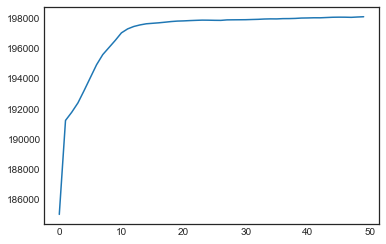

In [9]:
plt.plot(lls)

In [10]:
z = hmm.most_likely_states(y_valid)
hmm.permute(find_permutation(z_trues[w], z))
z = hmm.most_likely_states(y_valid)

Text(0,0.5,'$z$')

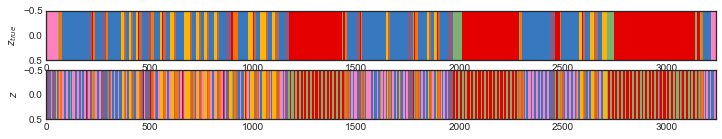

In [11]:
from matplotlib.gridspec import GridSpec
plt.figure(figsize=(12, 2))

plt.subplot(211)
plt.imshow(z_trues[w][None, :], aspect="auto", cmap=zplt.default_cmap, vmin=0, vmax=len(zplt.default_colors) -1)
plt.ylabel("$z_{true}$")

plt.subplot(212)
plt.imshow(z[None, :], aspect="auto", cmap=zplt.default_cmap, vmin=0, vmax=len(zplt.default_colors) -1)
plt.ylabel("$z$")

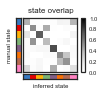

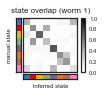

In [12]:
zplt.plot_state_overlap([z], [z_trues[w]])

In [14]:
E_z, E_zzp1 = hmm.expected_states(y_valid)

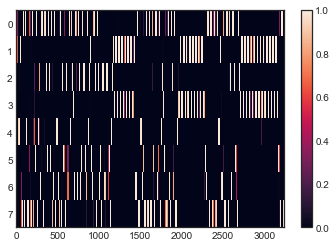

In [16]:
plt.imshow(E_z.T, aspect="auto", vmin=0, vmax=1)
plt.colorbar()

# Fit HMMs to each neuron

In [7]:
hmms = [HMM(C, 1, transitions="recurrent", observations="ar") for n in range(N)]

In [8]:
T, y, m = Ts[w], ys[w], ms[w]
z = np.zeros((T, N), dtype=int)
for n in range(N):
    print("Fitting neuron ", n)
    if m[0, n]:
        hmms[n].fit(y[:, n:n+1], method="em", num_em_iters=50, verbose=False)
        
        # permute the states based on their intensities
#         perm = np.argsort(hmms[n].observations.mus[:,0])
#         hmms[n].permute(perm)
        
        zn = hmms[n].most_likely_states(y[:, n:n+1])
        z[:, n] = zn

Fitting neuron  0
Fitting neuron  1
Fitting neuron  2
Fitting neuron  3
Fitting neuron  4
Fitting neuron  5
Fitting neuron  6
Fitting neuron  7
Fitting neuron  8
Fitting neuron  9
Fitting neuron  10
Fitting neuron  11
Fitting neuron  12
Fitting neuron  13
Fitting neuron  14
Fitting neuron  15
Fitting neuron  16
Fitting neuron  17
Fitting neuron  18
Fitting neuron  19
Fitting neuron  20
Fitting neuron  21
Fitting neuron  22
Fitting neuron  23
Fitting neuron  24
Fitting neuron  25
Fitting neuron  26
Fitting neuron  27
Fitting neuron  28
Fitting neuron  29
Fitting neuron  30
Fitting neuron  31
Fitting neuron  32
Fitting neuron  33
Fitting neuron  34
Fitting neuron  35
Fitting neuron  36
Fitting neuron  37
Fitting neuron  38
Fitting neuron  39
Fitting neuron  40
Fitting neuron  41
Fitting neuron  42
Fitting neuron  43
Fitting neuron  44
Fitting neuron  45
Fitting neuron  46
Fitting neuron  47
Fitting neuron  48
Fitting neuron  49
Fitting neuron  50
Fitting neuron  51
Fitting neuron  52
Fit

In [35]:
z_valid = z[:, n_valid]

Text(0,0.5,'$z$')

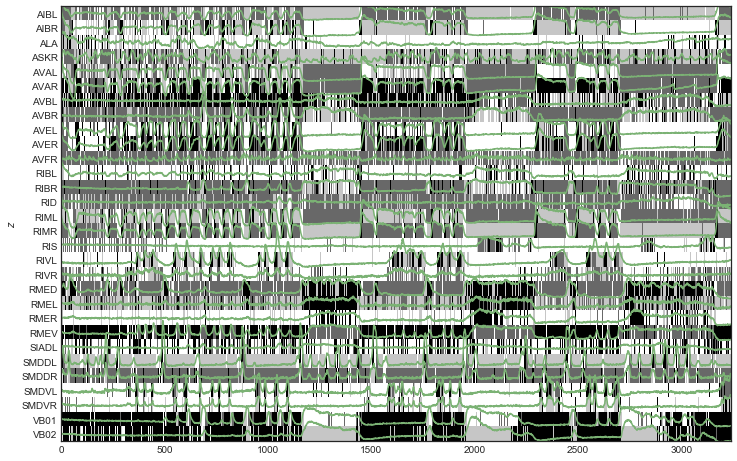

In [90]:
plt.figure(figsize=(12, 8))
plt.imshow(z_valid.T, aspect="auto", cmap="Greys", extent=(0, Ts[w], -N_valid+.5, 0.5))
plt.plot(y[:, m[0]] - np.arange(N_valid), color=zplt.default_colors[3])
plt.ylim(-N_valid+.5, .5)
plt.yticks(np.arange(0, -N_valid, -1), neuron_names[n_valid])
plt.ylabel("$z$")

# Now fit a "Super HMM" to the inferred discrete neural states

In [11]:
superhmm = HMM(K, D=N_valid, observations="categorical", observation_kwargs=dict(C=C))

In [12]:
lls = superhmm.fit(z_valid, method="em", num_em_iters=50)

Iteration 0.  LL: -72061.4
Iteration 1.  LL: -68071.3
Iteration 2.  LL: -66923.5
Iteration 3.  LL: -66544.0
Iteration 4.  LL: -66341.9
Iteration 5.  LL: -66196.7
Iteration 6.  LL: -66131.0
Iteration 7.  LL: -66089.4
Iteration 8.  LL: -66047.4
Iteration 9.  LL: -65946.8
Iteration 10.  LL: -65842.0
Iteration 11.  LL: -65825.6
Iteration 12.  LL: -65819.9
Iteration 13.  LL: -65810.9
Iteration 14.  LL: -65789.1
Iteration 15.  LL: -65759.3
Iteration 16.  LL: -65728.5
Iteration 17.  LL: -65706.8
Iteration 18.  LL: -65692.3
Iteration 19.  LL: -65681.4
Iteration 20.  LL: -65675.3
Iteration 21.  LL: -65668.7
Iteration 22.  LL: -65666.4
Iteration 23.  LL: -65664.6
Iteration 24.  LL: -65659.2
Iteration 25.  LL: -65652.5
Iteration 26.  LL: -65642.2
Iteration 27.  LL: -65620.0
Iteration 28.  LL: -65600.9
Iteration 29.  LL: -65593.3
Iteration 30.  LL: -65588.1
Iteration 31.  LL: -65583.0
Iteration 32.  LL: -65578.1
Iteration 33.  LL: -65575.7
Iteration 34.  LL: -65574.7
Iteration 35.  LL: -65574.4
It

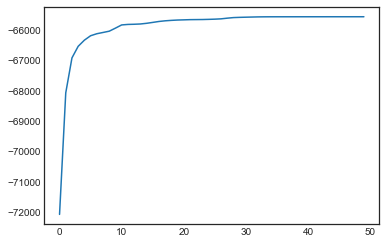

In [13]:
plt.plot(lls)

In [14]:
s = superhmm.most_likely_states(z_valid)
superhmm.permute(find_permutation(z_trues[w], s))
s = superhmm.most_likely_states(z_valid)

Text(0,0.5,'$z$')

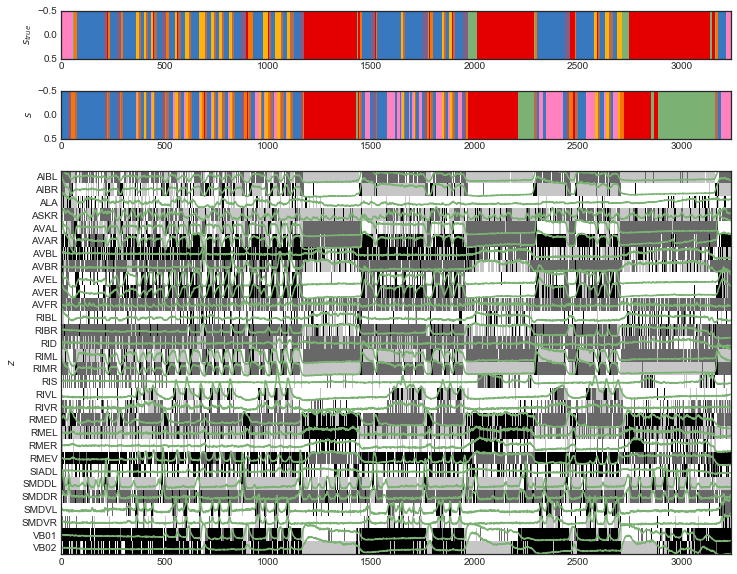

In [89]:
from matplotlib.gridspec import GridSpec
plt.figure(figsize=(12, 10))
gs = GridSpec(3, 1, height_ratios=[1, 1, 8])

plt.subplot(gs[0])
plt.imshow(z_trues[w][None, :], aspect="auto", cmap=zplt.default_cmap, vmin=0, vmax=len(zplt.default_colors) -1)
plt.ylabel("$s_{true}$")

plt.subplot(gs[1])
plt.imshow(s[None, :], aspect="auto", cmap=zplt.default_cmap, vmin=0, vmax=len(zplt.default_colors) -1)
plt.ylabel("$s$")

plt.subplot(gs[2])
plt.imshow(z_valid.T, aspect="auto", cmap="Greys", extent=(0, Ts[w], -N_valid+.5, 0.5))
plt.plot(y[:, m[0]] - np.arange(N_valid), color=zplt.default_colors[3])
plt.ylim(-N_valid+.5, .5)
plt.yticks(np.arange(0, -N_valid, -1), neuron_names[n_valid])
plt.ylabel("$z$")

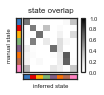

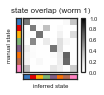

In [16]:
zplt.plot_state_overlap([s], [z_trues[w]])

Text(0.5,0.98,'Continuous Latent States (Inferred Labels)')

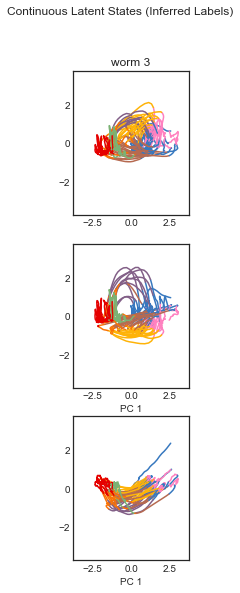

In [17]:
plt.figure(figsize=(12, 9))

ax = plt.subplot(3, W, w+1)
zplt.plot_2d_continuous_states(xs[w], s, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 1), ax=ax)
plt.ylabel("PC 2" if w == 0 else "")
plt.title("worm {}".format(w+1))

ax = plt.subplot(3, W, W+w+1)
zplt.plot_2d_continuous_states(xs[w], s, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 2), ax=ax)
plt.ylabel("PC 3" if w == 0 else "")
plt.xlabel("PC 1")

ax = plt.subplot(3, W, 2 * W+w+1)
zplt.plot_2d_continuous_states(xs[w], s, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 3), ax=ax)
plt.ylabel("PC 3" if w == 0 else "")
plt.xlabel("PC 1")
    
plt.suptitle("Continuous Latent States (Inferred Labels)")

Text(0.5,0.98,'Continuous Latent States (Zimmer Labels)')

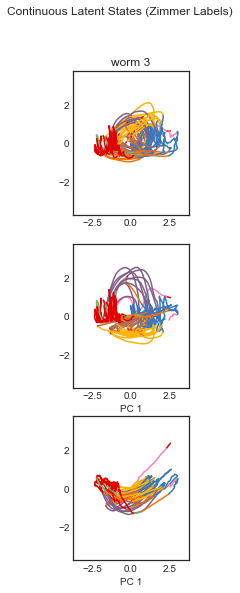

In [18]:
plt.figure(figsize=(12, 9))

ax = plt.subplot(3, W, w+1)
zplt.plot_2d_continuous_states(xs[w], z_trues[w], xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 1), ax=ax)
plt.ylabel("PC 2" if w == 0 else "")
plt.title("worm {}".format(w+1))

ax = plt.subplot(3, W, W+w+1)
zplt.plot_2d_continuous_states(xs[w], z_trues[w], xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 2), ax=ax)
plt.ylabel("PC 3" if w == 0 else "")
plt.xlabel("PC 1")

ax = plt.subplot(3, W, 2 * W+w+1)
zplt.plot_2d_continuous_states(xs[w], z_trues[w], xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 3), ax=ax)
plt.ylabel("PC 3" if w == 0 else "")
plt.xlabel("PC 1")
    
plt.suptitle("Continuous Latent States (Zimmer Labels)")

# Simulate from the model for a fixed super state sequence

In [69]:
z_smpl = np.array([superhmm.observations.sample_x(st, None) for st in s])  # T x N_valid
# z_smpl = z_valid.copy()
y_smpl = np.zeros((Ts[w], N_valid))
for t in range(Ts[w]):
    for i,n in enumerate(n_valid):
        y_smpl[t, i] = hmms[n].observations.sample_x(z_smpl[t, i], y_smpl[:t, i][:, None], with_noise=False)
        

In [70]:
# Throw out the unstable samples
bad = np.where(abs(y_smpl).max(0) > 3)[0]
y_good = y_smpl.copy()
y_good[:, bad] = np.nan
print("neurons with bad simulations: ", bad)

neurons with bad simulations:  [4]


Text(0.5,0,'time (s)')

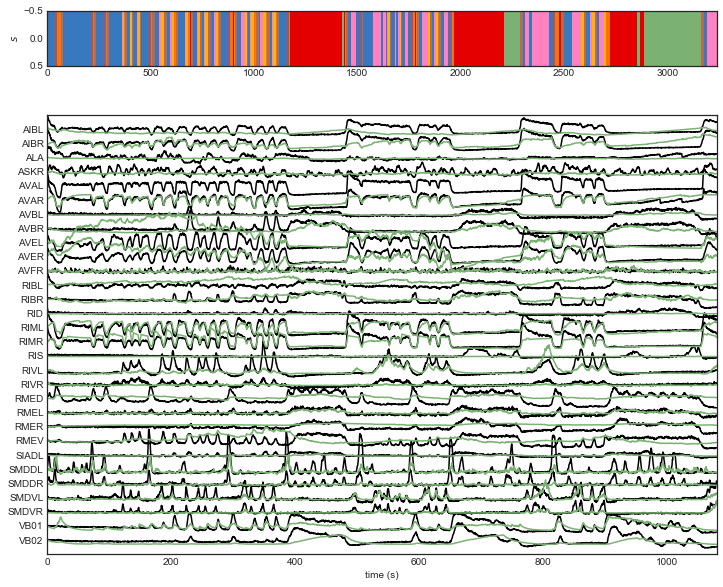

In [71]:
# Plot real data for comparison
plt.figure(figsize=(12, 10))
gs = GridSpec(2, 1, height_ratios=[1, 8])


plt.subplot(gs[0])
plt.imshow(s[None, :], aspect="auto", cmap=zplt.default_cmap, vmin=0, vmax=len(zplt.default_colors) -1)
plt.ylabel("$s$")

plt.subplot(gs[1])
plt.plot(np.arange(Ts[0]) / 3.0, ys[w][:,n_valid] - np.arange(N_valid), '-k')
plt.plot(np.arange(Ts[0]) / 3.0, y_good - np.arange(N_valid), '-', color=zplt.default_colors[3])
plt.yticks(-np.arange(N_valid), neuron_names[n_valid])
plt.ylim(-N_valid,1)
plt.xlim(0, Ts[0] / 3.0)
plt.xlabel("time (s)")


In [72]:
# plot the sampled neural activity in PCA space 
y_good[:, bad] = 0
x_good = y_good.dot(pca.components_.T[n_valid])
lim = 1.1 * abs(x_good).max()

# smooth
x_good = gaussian_filter1d(x_good, 1, axis=0)

Text(0.5,0.98,'PCA projection of sampled activity')

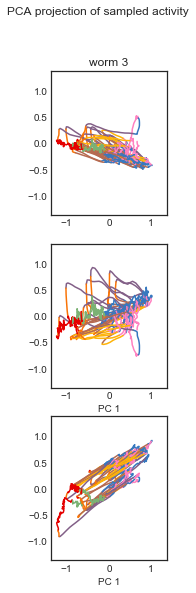

In [73]:
plt.figure(figsize=(12, 9))

ax = plt.subplot(3, W, w+1)
zplt.plot_2d_continuous_states(x_good, s, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 1), ax=ax)
plt.ylabel("PC 2" if w == 0 else "")
plt.title("worm {}".format(w+1))

ax = plt.subplot(3, W, W+w+1)
zplt.plot_2d_continuous_states(x_good, s, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 2), ax=ax)
plt.ylabel("PC 3" if w == 0 else "")
plt.xlabel("PC 1")

ax = plt.subplot(3, W, 2 * W+w+1)
zplt.plot_2d_continuous_states(x_good, s, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 3), ax=ax)
plt.ylabel("PC 3" if w == 0 else "")
plt.xlabel("PC 1")
    
plt.suptitle("PCA projection of sampled activity")

In [49]:
# Look at the AR parameters for stability
np.array([hmms[n].observations.As[:, 0, 0] for n in n_valid])

array([[1.01012147, 1.00147781, 0.98922125, 1.01110354],
       [1.00185176, 0.98841033, 0.95420605, 1.02585898],
       [0.96958399, 0.93838242, 0.99295378, 1.03572883],
       [0.9974616 , 0.93852794, 0.95931659, 0.99135072],
       [0.94151903, 1.03628107, 1.00307704, 1.09764904],
       [0.87994311, 0.9646876 , 1.00138082, 0.96566534],
       [1.08763756, 0.98821764, 0.95458367, 0.91285912],
       [0.93284956, 1.00058036, 0.97496385, 1.08582778],
       [0.99634449, 0.89643154, 1.03086177, 0.98949295],
       [0.98890578, 0.98577082, 1.01213037, 0.98296858],
       [0.92546185, 0.98540247, 0.82705848, 0.89835491],
       [1.00029506, 0.93691525, 0.90268026, 1.02217166],
       [0.99289999, 0.96453663, 0.99696954, 0.96597776],
       [1.06162353, 0.83306135, 0.94211688, 0.95975259],
       [0.9391931 , 0.9441807 , 0.98914514, 0.93483578],
       [0.91935131, 1.0008506 , 0.98028943, 1.06605424],
       [0.84577804, 1.02107343, 1.02057194, 0.95902347],
       [0.97081584, 0.94659197,

# Now sample the full model, starting witht he global state sequence

In [ ]:
# Sample the global state sequence
P = superhmm.transitions.transition_matrix
s_smpl = np.zeros(Ts[w], dtype=int)
s_smpl[0] = s[0]
for t in range(1, Ts[w]):
    s_smpl[t] = np.random.choice(K, p=P[s_smpl[t-1]])

Text(0,0.5,'$s sampled$')

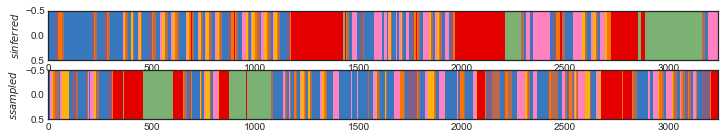

In [79]:
plt.figure(figsize=(12, 2))
gs = GridSpec(2, 1, height_ratios=[1, 1])


plt.subplot(gs[0])
plt.imshow(s[None, :], aspect="auto", cmap=zplt.default_cmap, vmin=0, vmax=len(zplt.default_colors) -1)
plt.ylabel("$s inferred$")

plt.subplot(gs[1])
plt.imshow(s_smpl[None, :], aspect="auto", cmap=zplt.default_cmap, vmin=0, vmax=len(zplt.default_colors) - 1)
plt.ylabel("$s sampled$")
                                   

In [80]:
z_smpl = np.array([superhmm.observations.sample_x(st, None) for st in s_smpl])  # T x N_valid
# z_smpl = z_valid.copy()
y_smpl = np.zeros((Ts[w], N_valid))
for t in range(Ts[w]):
    for i,n in enumerate(n_valid):
        y_smpl[t, i] = hmms[n].observations.sample_x(z_smpl[t, i], y_smpl[:t, i][:, None], with_noise=False)
        

In [81]:
# Throw out the unstable samples
bad = np.where(abs(y_smpl).max(0) > 3)[0]
y_good = y_smpl.copy()
y_good[:, bad] = np.nan
print("neurons with bad simulations: ", bad)

neurons with bad simulations:  [ 4  8 15]


Text(0.5,0,'time (s)')

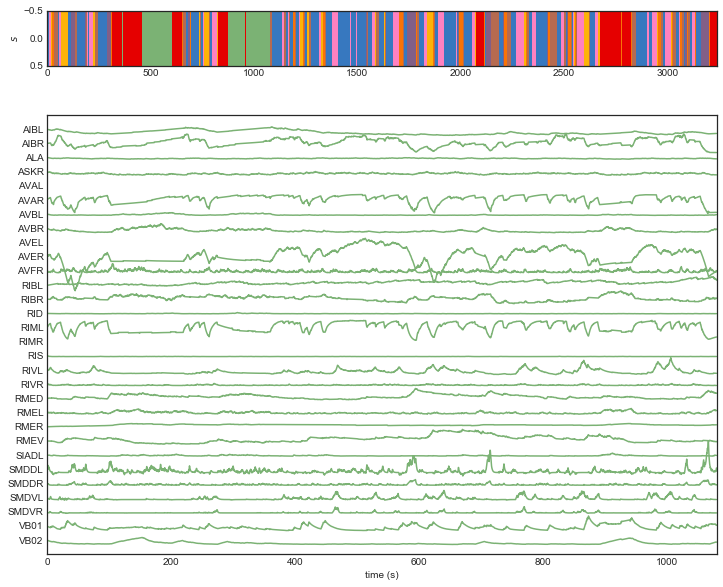

In [82]:
# Plot real data for comparison
plt.figure(figsize=(12, 10))
gs = GridSpec(2, 1, height_ratios=[1, 8])


plt.subplot(gs[0])
plt.imshow(s_smpl[None, :], aspect="auto", cmap=zplt.default_cmap, vmin=0, vmax=len(zplt.default_colors) -1)
plt.ylabel("$s$")

plt.subplot(gs[1])
# plt.plot(np.arange(Ts[0]) / 3.0, ys[w][:,n_valid] - np.arange(N_valid), '-k')
plt.plot(np.arange(Ts[0]) / 3.0, y_good - np.arange(N_valid), '-', color=zplt.default_colors[3])
plt.yticks(-np.arange(N_valid), neuron_names[n_valid])
plt.ylim(-N_valid,1)
plt.xlim(0, Ts[0] / 3.0)
plt.xlabel("time (s)")